# Discover

For inspiration on EDA for image analysis, I have learned from these notebooks: [SimpleEDA](https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch), [ChannelStats](https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93)

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from PIL import Image
import tensorflow as tf
import time
import zipfile
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import keras
%matplotlib inline
from google.colab import files

In [0]:
# Use this to upload the kaggle.json from your local machine:

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
def update_histogram_counts(histograms, batch_data, n_bins):
  """ This method keeps a running tally of histogram bins across multiple batches"""
  if histograms is not None:
    red_histogram = histograms[0] + np.histogram(batch_data[:,:,:,0].flatten(), bins=n_bins)[0]
    green_histogram = histograms[1] + np.histogram(batch_data[:,:,:,1].flatten(), bins=n_bins)[0]
    blue_histogram = histograms[2] + np.histogram(batch_data[:,:,:,2].flatten(), bins=n_bins)[0]
    rgb_histogram = histograms[3] + np.histogram(batch_data.flatten(), bins=n_bins)[0]
  else: # Initialize
    red_histogram = np.histogram(batch_data[:,:,:,0].flatten(), bins=n_bins)[0]
    green_histogram = np.histogram(batch_data[:,:,:,1].flatten(), bins=n_bins)[0]
    blue_histogram = np.histogram(batch_data[:,:,:,2].flatten(), bins=n_bins)[0]
    rgb_histogram = np.histogram(batch_data.flatten(), bins=n_bins)[0]

  return [red_histogram, green_histogram, blue_histogram, rgb_histogram]

def calc_image_statistics(data_generator, n_bins = 256):
  """ This method will use an ImageDataGenerator flow to go through all the training
  images and create histograms of the red, green, blue, and total intensity values for
  each of the positive and negative samples."""

  total_samples = data_generator.samples
  target_steps = np.floor((total_samples / data_generator.batch_size)) - 1
  
  prog_bar = tf.keras.utils.Progbar(
      target_steps,
      width=30,
      verbose=1,
      interval=0.05,
      stateful_metrics=None,
      unit_name='step')

  # Initialize
  batch = 0
  n_pos = n_neg = 0
  positive_histograms = None
  negative_histograms = None
  pos_means = []
  neg_means = []

  for x_batch, y_batch in data_generator:
      prog_bar.update(batch)

      # Grab the images that have been classified as positive for cancerous tissue:
      positive_samples = x_batch[y_batch==1,:,:,:]
      n_pos += positive_samples.shape[0]
      
      # Grab the images that have been classified as negative for cancerous tissue:
      negative_samples = x_batch[y_batch==0,:,:,:]
      n_neg += negative_samples.shape[0]

      positive_histograms = update_histogram_counts(positive_histograms, positive_samples, n_bins)
      negative_histograms = update_histogram_counts(negative_histograms, negative_samples, n_bins)
      pos_means.append(np.mean(positive_samples, axis=(1,2,3))) # want mean in all channels, axis 0 is image number
      neg_means.append(np.mean(negative_samples, axis=(1,2,3))) # want mean in all channels, axis 0 is image number

      batch += 1
      if batch >= (total_samples / data_generator.batch_size): 
        break # break the loop by hand because the generator loops indefinitely

  # Since we didn't know beforehand how many pos and neg samples in each batch. 
  # Now make one list with all the values:
  pos_mean_brightness = []
  for mean_values in pos_means:
    pos_mean_brightness.extend(mean_values.tolist())
  neg_mean_brightness = []
  for mean_values in neg_means:
    neg_mean_brightness.extend(mean_values.tolist())

  return [positive_histograms, negative_histograms, n_pos, n_neg, pos_mean_brightness, neg_mean_brightness]

The following plot is largely courtesy of [ChannelStats](https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93), except that I am including all of the samples by using tensorflow and doing my own histogram calculations:

In [0]:
def plot_channels(neg_counts, pos_counts, n_neg, n_pos, img_size, n_bins=256):
  n_pix = img_size[0] * img_size[1]

  fig, axs = plt.subplots(4, 2, sharey = True, figsize=(15, 15))

  # RGB channels
  axs[0,0].bar(range(n_bins), pos_hist[0] / (n_pos * n_pix), width = 1, color = 'r')
  axs[0,1].bar(range(n_bins), neg_hist[0] / (n_neg * n_pix), width = 1, color = 'r')
  axs[1,0].bar(range(n_bins), pos_hist[1] / (n_pos * n_pix), width = 1, color = 'g')
  axs[1,1].bar(range(n_bins), neg_hist[1] / (n_neg * n_pix), width = 1, color = 'g')
  axs[2,0].bar(range(n_bins), pos_hist[2] / (n_pos * n_pix), width = 1, color = 'b')
  axs[2,1].bar(range(n_bins), neg_hist[2] / (n_neg * n_pix), width = 1, color = 'b')

  # All channels
  axs[3,0].bar(range(n_bins), pos_hist[3] / (n_pos * n_pix), width = 1, color = 'k')
  axs[3,1].bar(range(n_bins), neg_hist[3] / (n_neg * n_pix), width = 1, color = 'k')

  # Axes labels
  axs[0,0].set_title("Positive samples (N = " + str(n_pos) + ")", fontsize = 18)
  axs[0,1].set_title("Negative samples (N = " + str(n_neg) + ")", fontsize = 18)
  axs[0,1].set_ylabel("Red", rotation='horizontal', labelpad=35, fontsize = 18)
  axs[1,1].set_ylabel("Green", rotation='horizontal', labelpad=35, fontsize = 18)
  axs[2,1].set_ylabel("Blue", rotation='horizontal', labelpad=35, fontsize = 18)
  axs[3,1].set_ylabel("RGB", rotation='horizontal', labelpad=35, fontsize = 18)
  #ax.tick_params(labelsize=8)

  for i in range(4):
      axs[i,0].set_ylabel("Relative Frequency",  fontsize = 18)
  axs[3,0].set_xlabel("Pixel value", fontsize = 18)
  axs[3,1].set_xlabel("Pixel value", fontsize = 18)
  fig.tight_layout()

## Download the data from Kaggle:

In [0]:
#!mkdir -p ~/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle config set -n path -v '/content/'
!kaggle competitions download histopathologic-cancer-detection

- path is now set to: /content/
  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 44.7MB/s]
 98% 5.00M/5.10M [00:00<00:00, 32.2MB/s]
100% 5.10M/5.10M [00:00<00:00, 32.6MB/s]
 99% 1.29G/1.30G [00:12<00:00, 104MB/s]
100% 1.30G/1.30G [00:12<00:00, 111MB/s]
100% 4.97G/4.98G [01:20<00:00, 142MB/s]
100% 4.98G/4.98G [01:21<00:00, 66.0MB/s]


In [0]:
root_dir = '/content/competitions/histopathologic-cancer-detection/'
root_logdir = os.path.join(root_dir, "tensorboard_logs")

In [0]:
# Unzip files in all zipped directories:
os.chdir(root_dir)

for path_to_zip_file in os.listdir():
    new_directory = os.path.splitext(path_to_zip_file)[0]
    os.makedirs(new_directory, exist_ok=True)
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
      zip_ref.extractall(new_directory)
      zip_ref.close()

In [0]:
! ls -l | head -10

total 6616984
drwxr-xr-x 2 root root       4096 Oct 22 17:36 sample_submission.csv
-rw-r--r-- 1 root root    1394488 Oct 22 17:30 sample_submission.csv.zip
drwxr-xr-x 8 root root       4096 Oct 22 18:06 tensorboard_logs
drwxr-xr-x 2 root root    4349952 Oct 22 17:36 test
-rw-r--r-- 1 root root 1401100547 Oct 22 17:31 test.zip
drwxr-xr-x 2 root root   16596992 Oct 22 17:36 train
drwxr-xr-x 2 root root       4096 Oct 22 17:34 train_labels.csv
-rw-r--r-- 1 root root    5352900 Oct 22 17:31 train_labels.csv.zip
-rw-r--r-- 1 root root 5346961539 Oct 22 17:33 train.zip


In [0]:
train_path = os.path.join(root_dir, 'train/')
test_path = os.path.join(root_dir, 'test/')
train_labels_path = os.path.join(root_dir, 'train_labels.csv/train_labels.csv')

## Load the labelled data:

In [0]:
plot_df = train_df.iloc[np.random.choice(train_df.index, 49)]
img_size = (96, 96)
pars = {'directory': train_path, 
                'x_col': 'id', # filenames of images
                'y_col': 'label', # class
                'target_size': img_size,
                'class_mode':'binary'}

plot_data_gen = ImageDataGenerator() 
plot_generator = train_data_gen.flow_from_dataframe(plot_df, batch_size = 1, **pars)

Found 49 validated image filenames belonging to 2 classes.


In [0]:
# This needs to be type str for the image data generator flow:
train_df = train_df.astype({'label': 'str'})

train_data_gen = ImageDataGenerator() 
train_generator = train_data_gen.flow_from_dataframe(train_df, batch_size = 10000, **pars)

Found 220025 validated image filenames belonging to 2 classes.


In [0]:
train_df = pd.read_csv(train_labels_path)
train_df['id'] = train_df['id'].apply(lambda x: x+".tif")

In [0]:
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [0]:
len(train_df)

220025

In [0]:
print(f'{len(os.listdir(train_path))} pictures in train.')
print(f'{len(os.listdir(test_path))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


## Visualize some images:

Max intensity span of image 32 in any channel:
42 91
Max intensity span of image 40 in any channel:
42 91


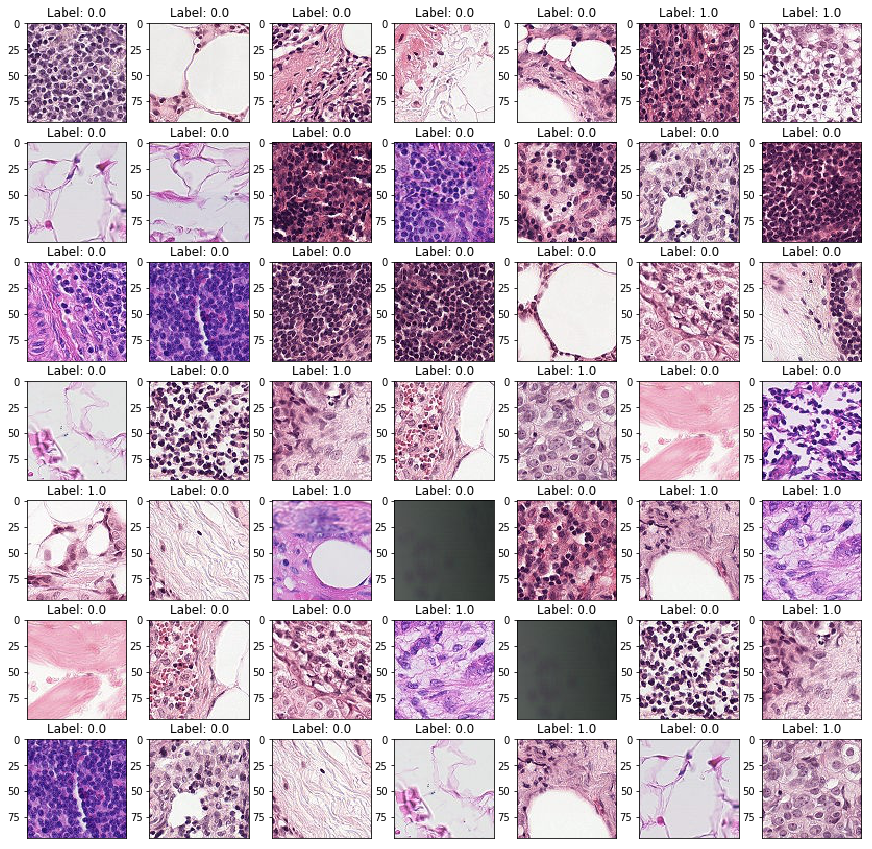

In [45]:
fig, axes = plt.subplots(nrows = 7, ncols = 7, figsize=(15, 15))
axes = axes.reshape(-1)

idx = 0 # Initialize
for x_batch, y_batch in plot_generator:
    if np.amax(x_batch[0].astype(int)) != 255:
      print(f"Max intensity span of image {idx+1} in any channel:",)
      print(np.amin(x_batch[0].astype(int)),np.amax(x_batch[0].astype(int)))
    axes[idx].imshow(x_batch[0].astype(int)) # only 1 image per batch
    #lab = y_batch[0]
    axes[idx].set_title(f'Label: {y_batch[0]}')
    axes[idx].set_xticks([], [])
    idx += 1
    if idx >= (plot_generator.samples / plot_generator.batch_size): 
        break # break the loop by hand because the generator loops indefinitely

* It looks like there are some images with a smaller contrast than the others

## Check that the training set is balanced:

In [0]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [0]:
train_df['label'].value_counts()/sum(train_df['label'].value_counts())

0    0.594969
1    0.405031
Name: label, dtype: float64

The training set is not balanced, we may need to compensate later.

## Channel Distributions

In [69]:
pos_hist, neg_hist, n_pos, n_neg, pos_mean_brightness, neg_mean_brightness = calc_image_statistics(plot_generator)

48/48 [==============================] - 0s 4ms/step


In [0]:
# Save the counts to file:

with open("positive_histograms.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(pos_hist)

files.download('positive_histograms.csv')


with open("negative_histograms.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(neg_hist)

files.download('negative_histograms.csv')

### Visualize channels using counts summed from all images:

The following plot is largely courtesy of [ChannelStats](https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93), except that I am including all of the samples by using tensorflow and doing my own histogram calculations:

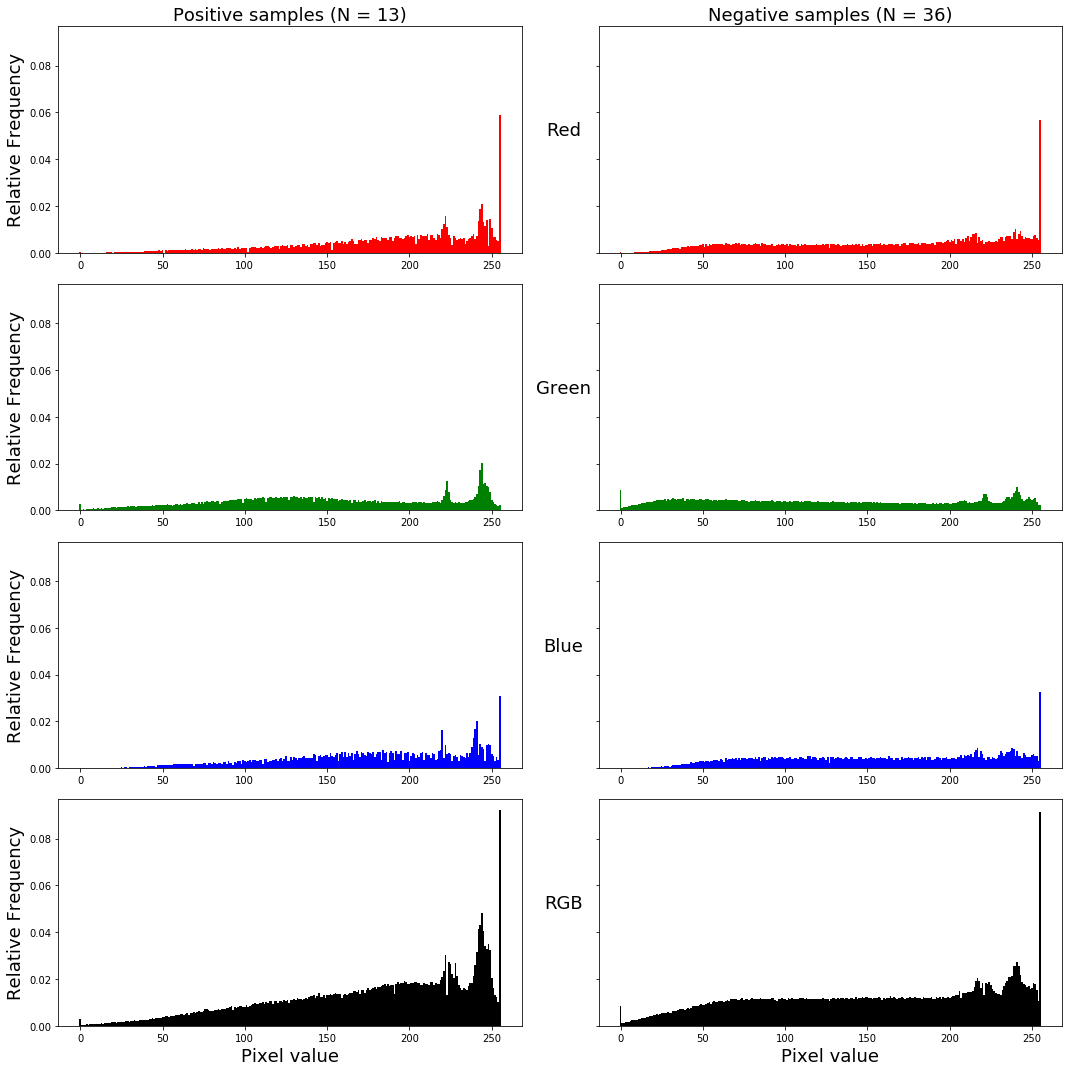

In [92]:
plot_channels(neg_hist, pos_hist, n_neg, n_pos, img_size)

### Observations:
* The negative samples have two or three bright peaks in all channels whereas the positive samples do not
* The red and blue channels have sharp high intensity spikes in all images
* The positive samples have a much lower mean in the green channel


## Mean image brightness:

Again, this plot is inspired by [ChannelStats](https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93),

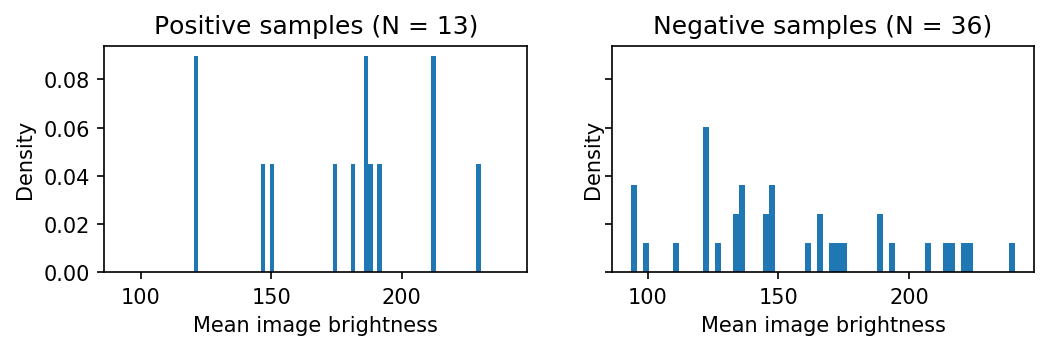

In [93]:
n_bins = 64
fig, axs = plt.subplots(1, 2, sharey=True, sharex = True, figsize=(8,2), dpi=150)
axs[0].hist(pos_mean_brightness, bins = n_bins, density=True);
axs[1].hist(neg_mean_brightness, bins = n_bins, density=True);
axs[0].set_title("Positive samples (N = " + str(n_pos) + ")");
axs[1].set_title("Negative samples (N = " + str(n_neg) + ")");
axs[0].set_xlabel("Mean image brightness")
axs[1].set_xlabel("Mean image brightness")
axs[0].set_ylabel("Density")
axs[1].set_ylabel("Density");